In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ast import literal_eval
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering,
                             Birch, MeanShift, AffinityPropagation, OPTICS, HDBSCAN)
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

import warnings
warnings.filterwarnings("ignore")

D:\4_course\VKR\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


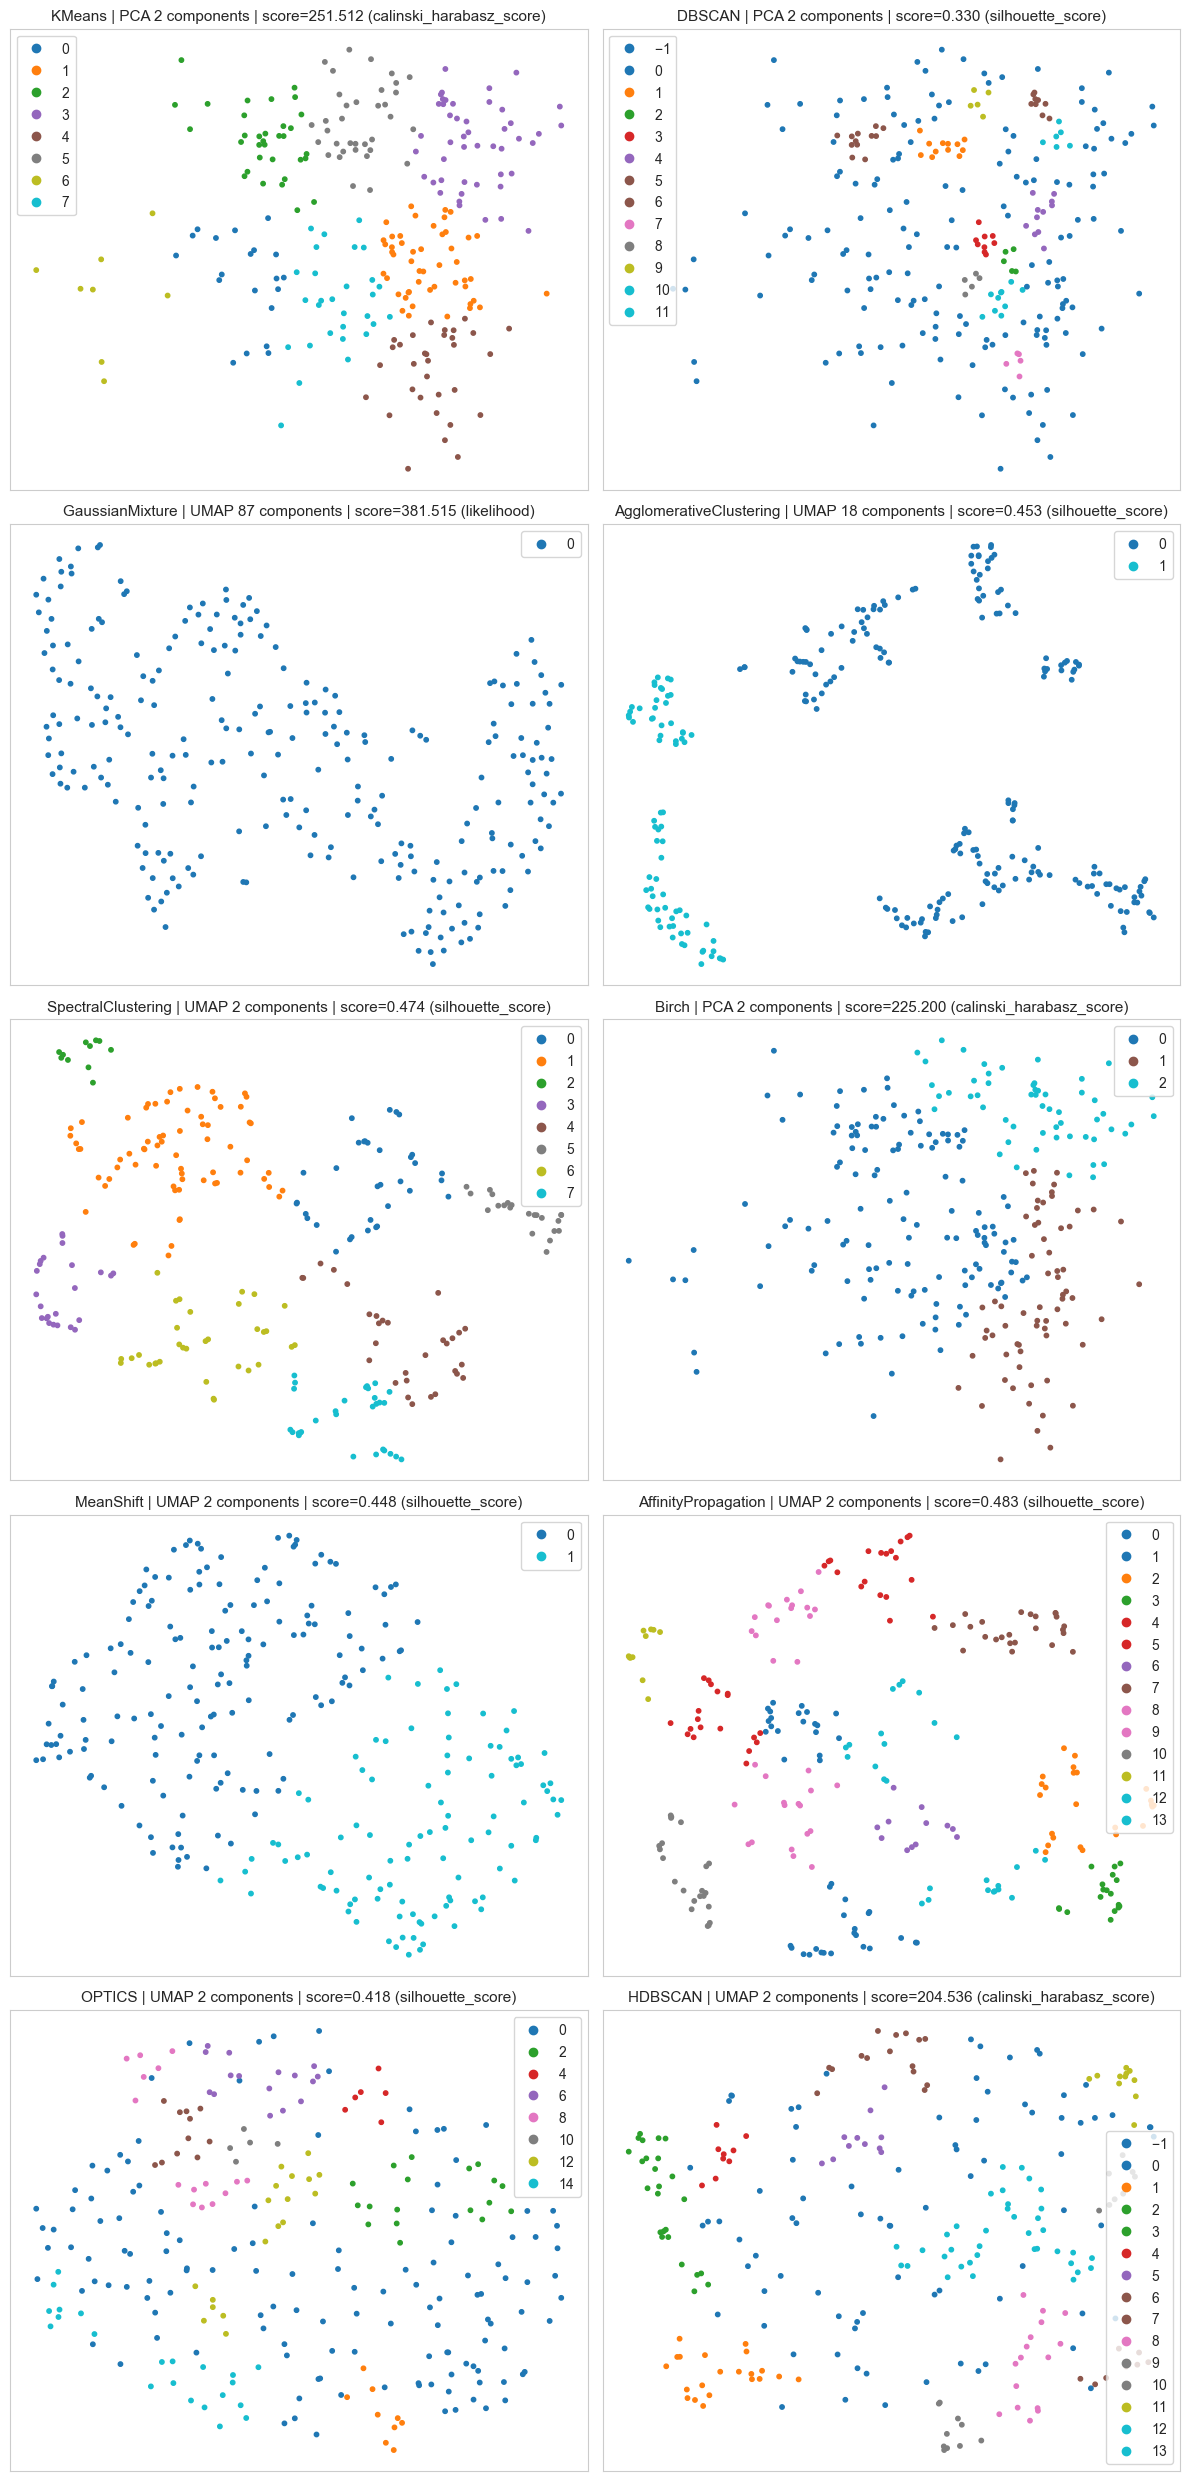

In [8]:
results = pd.read_csv('clustering_results.csv')
df = pd.read_csv('preprocessed/prepared_data.csv')
X_original = df.drop(columns=['КОД3 основной']).values

methods_map = {
    'KMeans': KMeans,
    'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering,
    'SpectralClustering': SpectralClustering,
    'Birch': Birch,
    'MeanShift': MeanShift,
    'AffinityPropagation': AffinityPropagation,
    'GaussianMixture': GaussianMixture,
    'OPTICS': OPTICS,
    'HDBSCAN': HDBSCAN,
}

n = len(results)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(12, n * 2.5))
axes = axes.flatten()

for i, row in results.iterrows():
    method = row['method']
    params = literal_eval(row['params'])
    score = row['score']
    scoring_metric = row['metric']

    reduction_method = params.pop('dimensionality_reduction', None)
    n_components = None
    
    if reduction_method == 'PCA':
        n_components = params.pop('pca_n_components')
        reducer = PCA(n_components=n_components, random_state=42)
        X = reducer.fit_transform(X_original)
    elif reduction_method == 'UMAP':
        n_components = params.pop('umap_n_components')
        n_neighbors = params.pop('umap_n_neighbors')
        min_dist = params.pop('umap_min_dist')
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors,
                            min_dist=min_dist, random_state=42)
        X = reducer.fit_transform(X_original)
    else:
        X = X_original

    model_cls = methods_map[method]
    params = {k.replace(f'{method}_', ''): v for k, v in params.items() if k.startswith(f'{method}_')}
    if method == 'GaussianMixture':
        model = model_cls(**params, random_state=42)
        labels = model.fit(X).predict(X)
    else:
        model = model_cls(**params)
        labels = model.fit_predict(X)

    if X.shape[1] > 2:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
        X_2d = tsne.fit_transform(X)
    else:
        X_2d = X

    ax = axes[i]
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=10)
    ax.legend(*scatter.legend_elements(), loc='best', fontsize=10)

    ax.set_title(f'{method} | {reduction_method} {n_components if n_components else ""} components | score={score:.3f} ({scoring_metric})', fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig('cluster_visualizations.png', dpi=300)
plt.show()

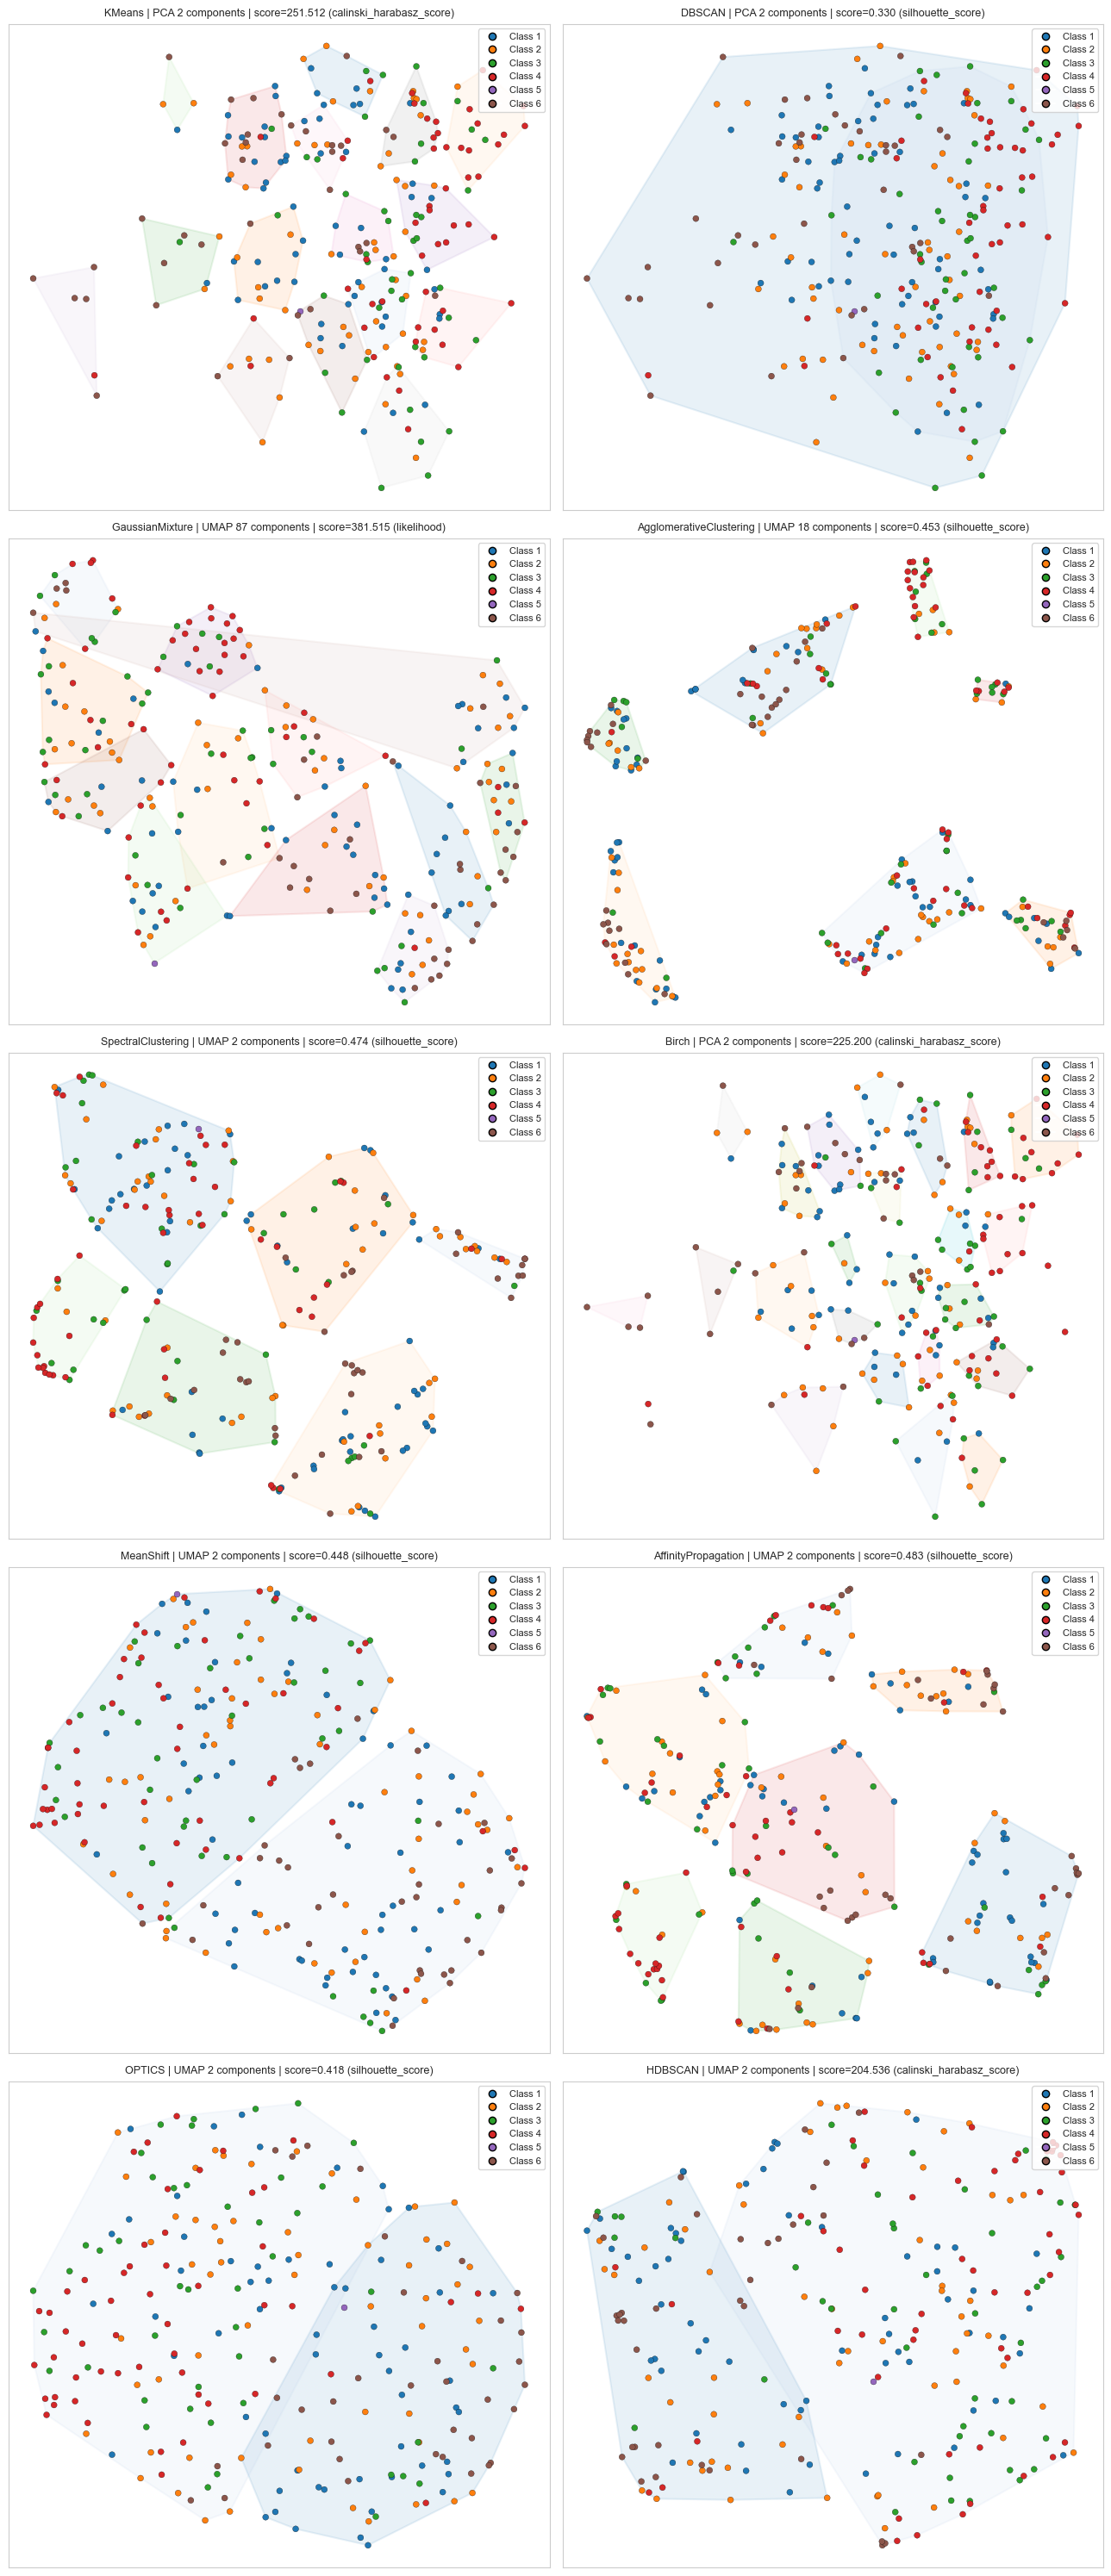

In [21]:
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
import matplotlib.patches as patches

true_labels = df['КОД3 основной'].values

unique_true = np.unique(true_labels)
true_label_to_color = {label: plt.cm.tab10(i % 10) for i, label in enumerate(unique_true)}
def draw_convex_hull(ax, points, color, alpha=0.1):
    if len(points) >= 3:
        try:
            hull = ConvexHull(points)
            polygon = patches.Polygon(points[hull.vertices], closed=True,
                                       facecolor=color, edgecolor=color,
                                       alpha=alpha, linewidth=1.5)
            ax.add_patch(polygon)
        except:
            pass

n = len(results)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(13, n * 3))
axes = axes.flatten()

for i, row in results.iterrows():
    method = row['method']
    params = literal_eval(row['params'])
    score = row['score']
    scoring_metric = row['metric']

    reduction_method = params.pop('dimensionality_reduction', None)
    n_components = None

    if reduction_method == 'PCA':
        n_components = params.pop('pca_n_components')
        reducer = PCA(n_components=n_components, random_state=42)
        X = reducer.fit_transform(X_original)
    elif reduction_method == 'UMAP':
        n_components = params.pop('umap_n_components')
        n_neighbors = params.pop('umap_n_neighbors')
        min_dist = params.pop('umap_min_dist')
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors,
                            min_dist=min_dist, random_state=42)
        X = reducer.fit_transform(X_original)
    else:
        X = X_original

    model_cls = methods_map[method]
    if method == 'GaussianMixture':
        model = model_cls(**params, random_state=42)
        predicted_labels = model.fit(X).predict(X)
    else:
        model = model_cls(**params)
        predicted_labels = model.fit_predict(X)

    if X.shape[1] > 2:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
        X_2d = tsne.fit_transform(X)
    else:
        X_2d = X

    ax = axes[i]
    
    cluster_labels_unique = np.unique(predicted_labels)
    cluster_label_to_color = {
        label: plt.cm.tab20(i % 20) for i, label in enumerate(cluster_labels_unique)
    }

    for label in cluster_labels_unique:
        points = X_2d[predicted_labels == label]
        color = cluster_label_to_color[label]
        draw_convex_hull(ax, points, color)

    for label in unique_true:
        idx = true_labels == label
        colors = [true_label_to_color[label]] * np.sum(idx)
        ax.scatter(
            X_2d[idx, 0], X_2d[idx, 1],
            c=colors,
            marker='o',
            s=25,
            edgecolors='k',
            linewidths=0.2
        )

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Class {label}',
               markerfacecolor=true_label_to_color[label], markersize=6, markeredgecolor='black')
        for label in unique_true
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    ax.set_title(f'{method} | {reduction_method} {n_components if n_components else ""} components | score={score:.3f} ({scoring_metric})', fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

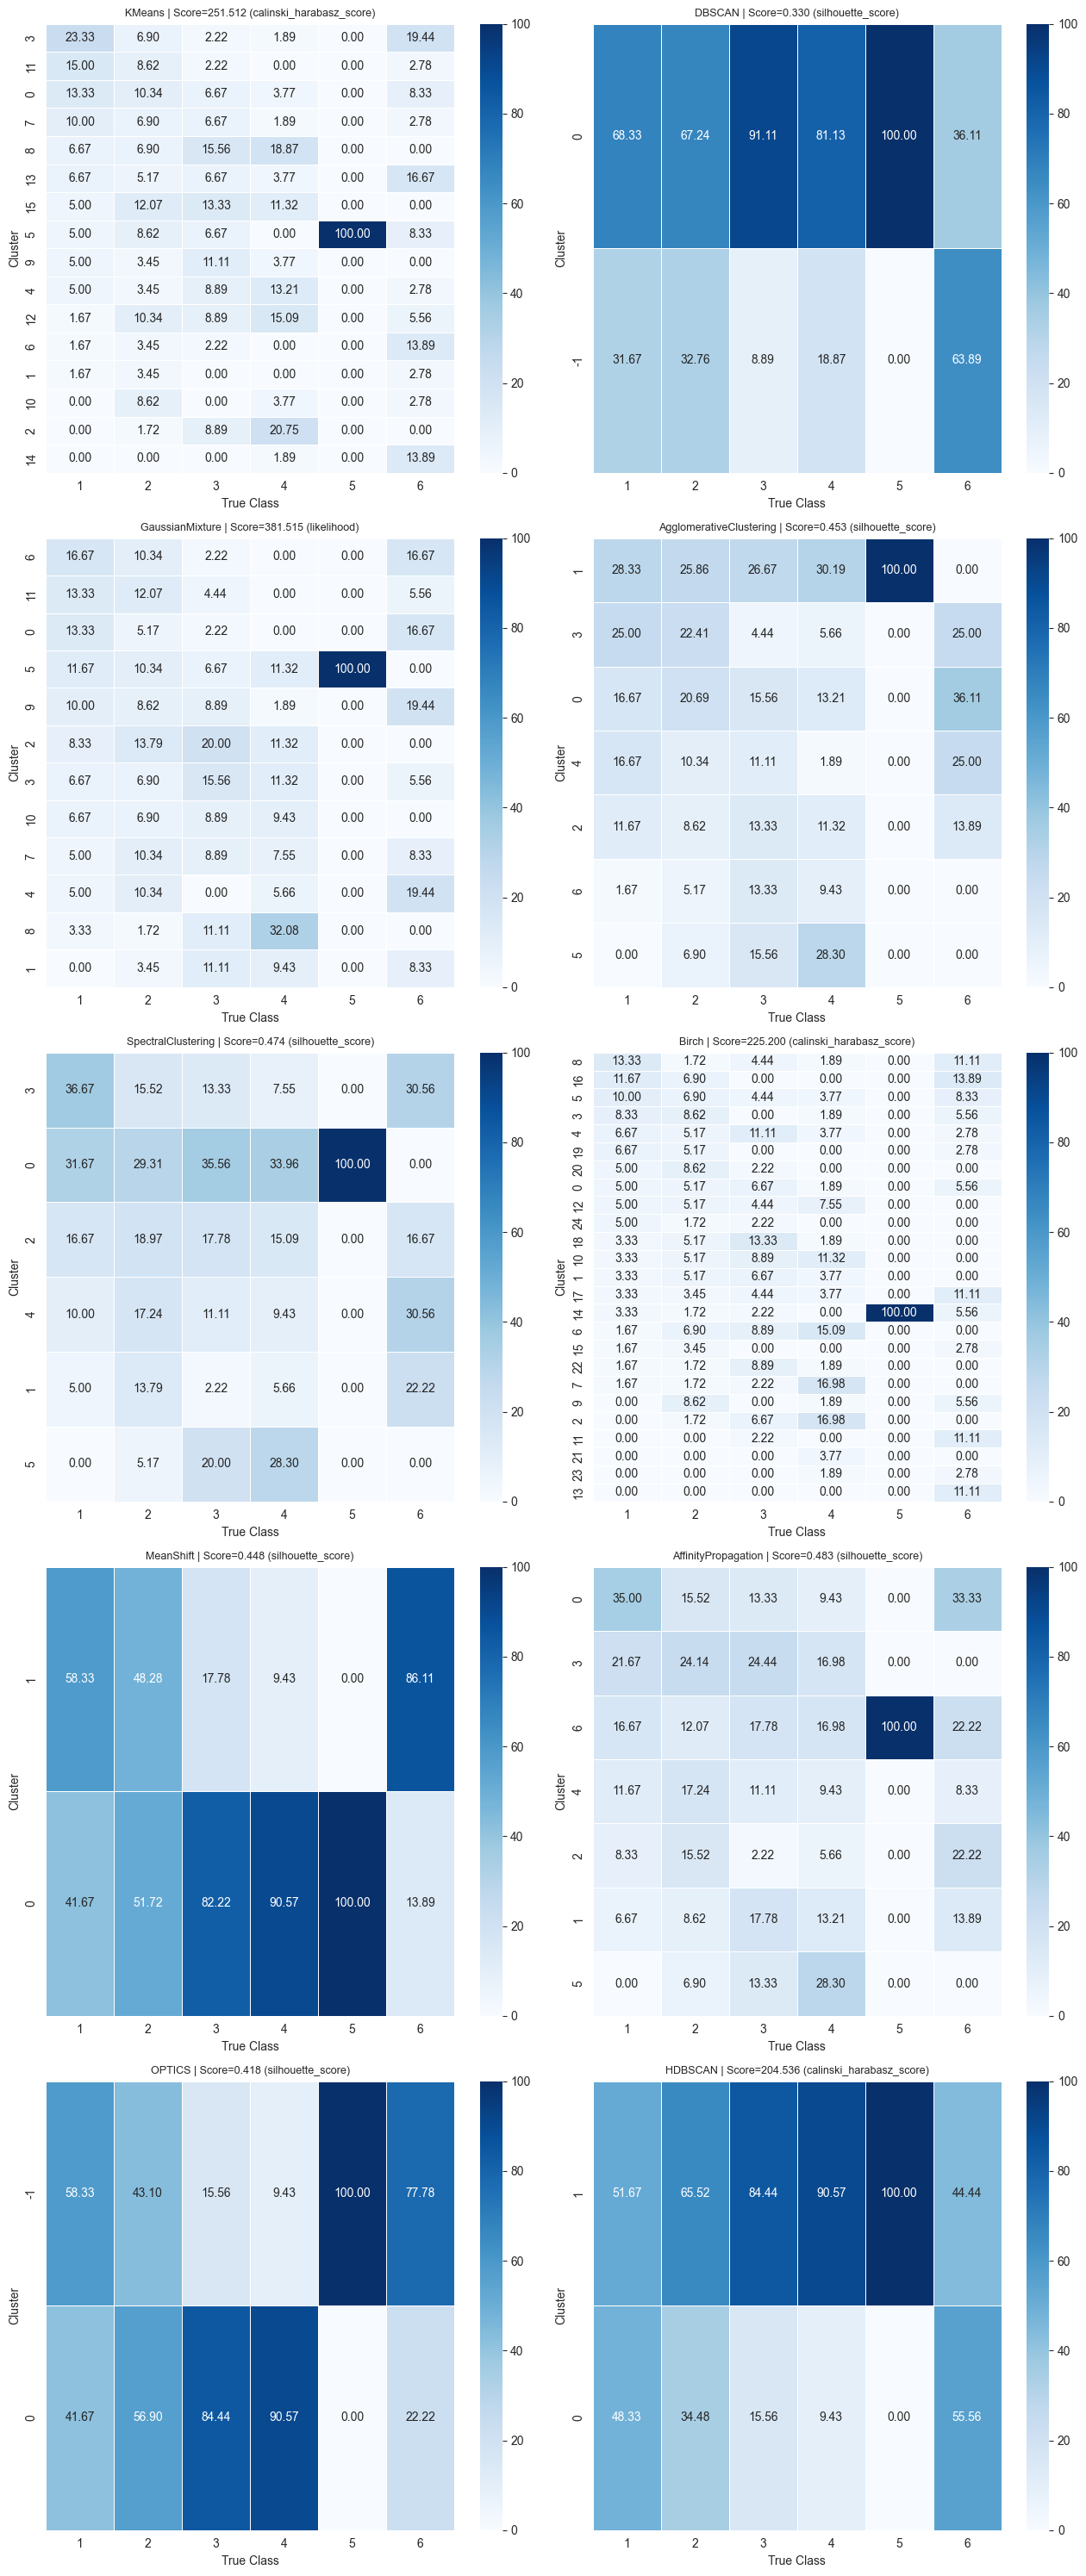

In [22]:
n = len(results)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(13, n * 3))
axes = axes.flatten()

method_cluster_percentages = {}

for i, row in results.iterrows():
    method = row['method']
    params = literal_eval(row['params'])
    
    reduction_method = params.pop('dimensionality_reduction', None)
    if reduction_method == 'PCA':
        n_components = params.pop('pca_n_components')
        reducer = PCA(n_components=n_components, random_state=42)
        X = reducer.fit_transform(X_original)
    elif reduction_method == 'UMAP':
        n_components = params.pop('umap_n_components')
        n_neighbors = params.pop('umap_n_neighbors')
        min_dist = params.pop('umap_min_dist')
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors,
                            min_dist=min_dist, random_state=42)
        X = reducer.fit_transform(X_original)
    else:
        X = X_original

    model_cls = methods_map[method]
    if method == 'GaussianMixture':
        model = model_cls(**params, random_state=42)
        predicted_labels = model.fit(X).predict(X)
    else:
        model = model_cls(**params)
        predicted_labels = model.fit_predict(X)

    cluster_percentages = []
    unique_clusters = np.unique(predicted_labels)
    unique_true = np.unique(true_labels)
    
    for cluster in unique_clusters:
        cluster_data = true_labels[predicted_labels == cluster]
        class_percentages = []
        for label in unique_true:
            class_in_cluster = np.sum(cluster_data == label)
            total_class_size = np.sum(true_labels == label)
            class_percentage = (class_in_cluster / total_class_size) * 100
            class_percentages.append(class_percentage)
        
        cluster_percentages.append(class_percentages)
    
    cluster_percentages = np.array(cluster_percentages)
    df_percentages = pd.DataFrame(cluster_percentages, columns=unique_true, index=unique_clusters)
    df_percentages = df_percentages.sort_values(by=list(df_percentages.columns), ascending=False)
    method_cluster_percentages[method] = df_percentages

    ax = axes[i]
    sns.heatmap(df_percentages, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=ax, linewidths=0.5)
    ax.set_title(f'{method} | Score={row["score"]:.3f} ({row["metric"]})', fontsize=9)
    ax.set_ylabel('Cluster')
    ax.set_xlabel('True Class')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import silhouette_score

method_scores = []
for i, row in results.iterrows():
    method = row['method']
    params = literal_eval(row['params'])
    reduction_method = params.pop('dimensionality_reduction', None)
    if reduction_method == 'PCA':
        n_components = params.pop('pca_n_components')
        reducer = PCA(n_components=n_components, random_state=42)
        X = reducer.fit_transform(X_original)
    elif reduction_method == 'UMAP':
        n_components = params.pop('umap_n_components')
        n_neighbors = params.pop('umap_n_neighbors')
        min_dist = params.pop('umap_min_dist')
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors,
                            min_dist=min_dist, random_state=42)
        X = reducer.fit_transform(X_original)
    else:
        X = X_original

    model_cls = methods_map[method]
    if method == 'GaussianMixture':
        model = model_cls(**params, random_state=42)
        predicted_labels = model.fit(X).predict(X)
    else:
        model = model_cls(**params)
        predicted_labels = model.fit_predict(X)

    if method != 'DBSCAN' or np.all(predicted_labels != -1):
        score = silhouette_score(X, predicted_labels)
        method_scores.append({
            'method': method,
            'score': score
        })

method_scores_df = pd.DataFrame(method_scores)
method_scores_df = method_scores_df.sort_values(by='score', ascending=False)
method_scores_df

,method,score
6,AffinityPropagation,0.483229
3,SpectralClustering,0.474294
2,AgglomerativeClustering,0.453232
5,MeanShift,0.447568
7,OPTICS,0.418244
8,HDBSCAN,0.407305
0,KMeans,0.366748
4,Birch,0.361278
1,GaussianMixture,0.238543
